In [1]:
!pip install transformers
!pip install -q hazm
!git clone https://github.com/amnghd/Persian_poems_corpus.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Cloning into 'Persian_poems_corpus'...
fatal: unable to access 'https://github.com/amnghd/Persian_poems_corpus.git/': OpenSSL SSL_connect: Connection was reset in connection to github.com:443 


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
%matplotlib inline
from transformers import BertTokenizer
from transformers import BertModel
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

import hazm
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import random
device = "cuda" if torch.cuda.is_available() else "cpu"


In [17]:
### NEEDED FUNCTION AND CLASSES ###

def generate_dataframe(folder_path):
    files = os.listdir(folder_path)
    poem_files = [f for f in files if f.endswith('.txt')]
    selected_poems = random.sample(poem_files, 10)

    data = pd.DataFrame(columns=['beyt', 'poet'])

    for poem_file in selected_poems:
        df = pd.read_csv(os.path.join(folder_path, poem_file), header=None)
        poet = poem_file.split(".")[0]
        lst = [''] * int(len(df) / 2)
        df_beyt = pd.DataFrame(lst, columns=['beyt'])
        for i in range(int(len(df) / 2)):
            df_beyt.iloc[i] = df.iloc[2 * i] + ' [SEP] ' + df.iloc[2 * i + 1]
        df_beyt['poet'] = poet
        data = pd.concat([data, df_beyt], ignore_index=True, sort=False)
        # Create a LabelEncoder object
        le = LabelEncoder()

          # Fit the LabelEncoder object to the target column
        le.fit(data['poet'])

        # Transform the target column to numerical values
        data['poet_encoded'] = le.transform(data['poet'])
    return data.sample(frac=1).reset_index(drop=True)

class PersianPoemsDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Persian poems corpus. """
    def __init__(self, df):
        poets = data.poet.unique()
        poet_encoded = [data[data.poet == poet].poet_encoded.values[0] for poet in poets]
        poet_dict = dict(zip(poets, poet_encoded))
        self.labels = [poet_dict[label] for label in df['poet']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 35, truncation=True,return_tensors="pt") for text in df['beyt']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], np.array(self.labels[idx])
ParsBERT = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
class PoemClassifier(nn.Module):
    def __init__(self,is_freeze=True):
        super(PoemClassifier, self).__init__()
        self.bert = ParsBERT
        if is_freeze:
          for param in self.bert.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(768, 10)
    def forward(self, input_ids, attention_mask): 
        return self.fc(self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[1])

def report_model(model,dataloader,name=''): #confusion matrix , ... 
    y_true = []
    y_pred = []
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=inputs['input_ids'].squeeze(1).to(device), attention_mask=inputs['attention_mask'].to(device))
        y_true.extend(labels.tolist())
        y_pred.extend(outputs.argmax(1).tolist())
    print(f'~~~~~~~~~~~~ {name} ~~~~~~~~~~~~ \n')
    print(classification_report(y_true, y_pred, target_names=poets))
    print(f'confusion matrix : \n {confusion_matrix(y_true, y_pred)}')
    print(f'f1_score : {f1_score(y_true, y_pred, average="macro")}')

### perplexity Compartion ##
def perplexity(model1, model2, test_dataloader,criterion):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model1 = model1.cuda()
        model2 = model2.cuda()
    total_loss_model1 = 0
    total_loss_model2 = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output1 = model1(input_id, mask)
            output2 = model2(input_id, mask)
            batch_loss1 = criterion(output1, test_label.long())
            batch_loss2 = criterion(output2, test_label.long())
            total_loss_model1 += batch_loss1.item()
            total_loss_model2 += batch_loss2.item()
    perplexity_model1 = np.exp(total_loss_model1 / len(test_dataloader))
    perplexity_model2 = np.exp(total_loss_model2 / len(test_dataloader))
    return perplexity_model1, perplexity_model2


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# load randomly 10 poems data ###
data = generate_dataframe('/content/Persian_poems_corpus/normalized')
data

,beyt,poet,poet_encoded
0,در راه تو نیست عاشقان را [SEP] جز داعیه تو ره ...,sanaee_norm,7
1,چو روی او نگری فر خجسته گردد فال [SEP] اگر بهم...,onsori_norm,4
2,قرآن رهاننده ز دوزخ چو بهشتست [SEP] زیرا که بی...,seyf_norm,8
3,ور نه بس فخری نباشد مر سها را از فلک [SEP] چون...,sanaee_norm,7
4,که آمد بنزدیک او گلگله [SEP] ابا لشکری چون هژب...,ferdousi_norm,1
...,...,...,...
149276,ور بمانی نه کم وقار شوی [SEP] چه ضرورت به ترک ...,ouhadi_norm,5
149277,کرده ای پنهان محیط بیکران [SEP] قطره ای زان در...,feyz_norm,2
149278,نهادند بر گردنش پالهنگ [SEP] دو دست از پس پشت ...,ferdousi_norm,1
149279,گولی تو از قیاس که گر بر کشد کسی [SEP] یک کوزه...,onsori_norm,4


In [5]:
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

e:\Python310\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zolghadr\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
df_train, df_val, df_test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])
### balance df_train . number of poems from each poet should be equal ### 
df_train = df_train.groupby('poet_encoded').apply(lambda x: x.sample(df_train['poet_encoded'].value_counts().max(), replace=True)).reset_index(drop=True)

## create torch dataloader and dataset ##
train_dataset, val_dataset, test_dataset = PersianPoemsDataset(df_train), PersianPoemsDataset(df_val), PersianPoemsDataset(df_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [7]:
# find unique poets in the dataset . i select poets randomly
poets = data.poet.unique()
poet_encoded = [data[data.poet == poet].poet_encoded.values[0] for poet in poets]
poet_dict = dict(zip(poets, poet_encoded))
poet_dict

{'sanaee_norm': 7,
 'onsori_norm': 4,
 'seyf_norm': 8,
 'ferdousi_norm': 1,
 'feyz_norm': 2,
 'eraghi_norm': 0,
 'ouhadi_norm': 5,
 'kamal_norm': 3,
 'vahshi_norm': 9,
 'roodaki_norm': 6}

In [8]:
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, learning_rate, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)
    total_loss_train_array = []
    total_loss_val_array = []
    total_loss_test_array = []
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_acc_val = 0
            total_loss_val = 0
            total_loss_test = 0
            total_acc_test = 0

            for train_input, train_label in tqdm(train_dataloader):
                model.train()
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            ### evalute ### 
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    model.eval()
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                for test_input, test_label in test_dataloader:
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, test_label.long())
                    total_loss_test += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == test_label).sum().item()
                    total_acc_test += acc
                
            
            print(f"Epoch: {epoch_num+1}/{epochs}")
            print(f"Train Loss: {total_loss_train/len(train_dataloader):.4f} | Train Acc: {total_acc_train/len(train_dataset):.4f}")
            print(f"Val Loss: {total_loss_val/len(val_dataloader):.4f} | Val Acc: {total_acc_val/len(val_dataset):.4f}")
            print(f"Test Loss: {total_loss_test/len(test_dataloader):.4f} | Test Acc: {total_acc_test/len(test_dataset):.4f}")
            print('--------------------------------------')
            total_loss_train_array.append(total_loss_train/len(train_dataloader))
            total_loss_val_array.append(total_loss_val/len(val_dataloader))
            total_loss_test_array.append(total_loss_test/len(test_dataloader))

    ### plot result ###
    plt.title('Loss')
    plt.plot(total_loss_train_array, label='train')
    plt.plot(total_loss_val_array, label='validation')
    plt.plot(total_loss_test_array, label='test')
    plt.legend()
    plt.show() 
    return model,total_loss_train_array,total_loss_test_array,total_loss_val_array



100%|██████████| 12390/12390 [04:20<00:00, 47.62it/s]


Epoch: 1/5
Train Loss: 2.0132 | Train Acc: 0.2790
Val Loss: 1.7538 | Val Acc: 0.4021
Test Loss: 1.7558 | Test Acc: 0.4032
--------------------------------------


100%|██████████| 12390/12390 [04:20<00:00, 47.50it/s]


Epoch: 2/5
Train Loss: 1.9268 | Train Acc: 0.3145
Val Loss: 1.6387 | Val Acc: 0.4463
Test Loss: 1.6403 | Test Acc: 0.4438
--------------------------------------


100%|██████████| 12390/12390 [04:15<00:00, 48.41it/s]


Epoch: 3/5
Train Loss: 1.9013 | Train Acc: 0.3253
Val Loss: 1.6407 | Val Acc: 0.4475
Test Loss: 1.6425 | Test Acc: 0.4473
--------------------------------------


100%|██████████| 12390/12390 [04:18<00:00, 47.88it/s]


Epoch: 4/5
Train Loss: 1.8864 | Train Acc: 0.3316
Val Loss: 1.6468 | Val Acc: 0.4401
Test Loss: 1.6474 | Test Acc: 0.4412
--------------------------------------


100%|██████████| 12390/12390 [04:18<00:00, 47.92it/s]


Epoch: 5/5
Train Loss: 1.8757 | Train Acc: 0.3355
Val Loss: 1.6758 | Val Acc: 0.4273
Test Loss: 1.6755 | Test Acc: 0.4265
--------------------------------------


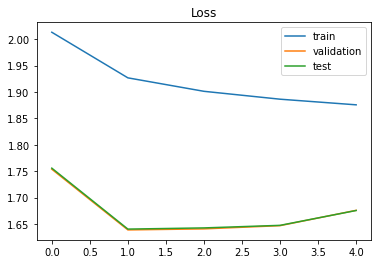

In [9]:
#### Freeze PRETRAINED WITH ADAM ###
model_freeze_ADAM = PoemClassifier(is_freeze = True)
EPOCHS = 5
LR = 2e-4


criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_freeze_ADAM.parameters(), lr= LR)
              
model_freeze_ADAM, total_loss_train_array_freeze_ADAM,total_loss_test_array_freeze_ADAM,total_loss_val_array_freeze_ADAM = train_and_evaluate(model_freeze_ADAM, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
#save model and result
torch.save(model_freeze_ADAM.state_dict(), 'model_freeze_ADAM.pt')
np.save('total_loss_train_array_freeze_ADAM.npy', total_loss_train_array_freeze_ADAM)
np.save('total_loss_test_array_freeze_ADAM.npy', total_loss_test_array_freeze_ADAM)
np.save('total_loss_val_array_freeze_ADAM.npy', total_loss_val_array_freeze_ADAM)


In [10]:
## confusion matrix , ... ##
report_model(model_freeze_ADAM,test_dataloader, 'Freeze with Adam')

~~~~~~~~~~~~ Freeze with Adam ~~~~~~~~~~~~ 

               precision    recall  f1-score   support

  sanaee_norm       0.19      0.20      0.20       587
  onsori_norm       0.88      0.71      0.79      4959
    seyf_norm       0.32      0.39      0.35       992
ferdousi_norm       0.40      0.21      0.28      1516
    feyz_norm       0.13      0.54      0.21       376
  eraghi_norm       0.25      0.33      0.28      1429
  ouhadi_norm       0.03      0.33      0.05       100
   kamal_norm       0.51      0.23      0.32      2678
  vahshi_norm       0.31      0.33      0.32      1264
 roodaki_norm       0.27      0.28      0.27      1028

     accuracy                           0.43     14929
    macro avg       0.33      0.36      0.31     14929
 weighted avg       0.53      0.43      0.46     14929

confusion matrix : 
 [[ 120   16   96   19   32  130   29   42   50   53]
 [  45 3507   58   71  383  223  378   89   54  151]
 [  74   11  391   55   72  122   54   64   93   56]
 [

100%|██████████| 12390/12390 [04:40<00:00, 44.15it/s]


Epoch: 1/5
Train Loss: 2.2616 | Train Acc: 0.1673
Val Loss: 2.1431 | Val Acc: 0.3260
Test Loss: 2.1438 | Test Acc: 0.3241
--------------------------------------


100%|██████████| 12390/12390 [04:57<00:00, 41.62it/s]


Epoch: 2/5
Train Loss: 2.1931 | Train Acc: 0.2178
Val Loss: 2.0650 | Val Acc: 0.3355
Test Loss: 2.0665 | Test Acc: 0.3329
--------------------------------------


100%|██████████| 12390/12390 [04:58<00:00, 41.56it/s]


Epoch: 3/5
Train Loss: 2.1533 | Train Acc: 0.2339
Val Loss: 2.0053 | Val Acc: 0.3508
Test Loss: 2.0068 | Test Acc: 0.3435
--------------------------------------


100%|██████████| 12390/12390 [04:26<00:00, 46.44it/s]


Epoch: 4/5
Train Loss: 2.1264 | Train Acc: 0.2438
Val Loss: 1.9724 | Val Acc: 0.3528
Test Loss: 1.9737 | Test Acc: 0.3454
--------------------------------------


100%|██████████| 12390/12390 [04:24<00:00, 46.88it/s]


Epoch: 5/5
Train Loss: 2.1067 | Train Acc: 0.2506
Val Loss: 1.9484 | Val Acc: 0.3589
Test Loss: 1.9490 | Test Acc: 0.3515
--------------------------------------


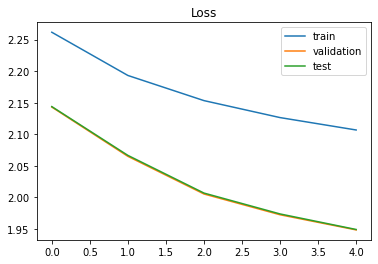

In [11]:
#### Freeze PRETRAINED WITH SGD ###
model_freeze_SGD = PoemClassifier(is_freeze = True)
EPOCHS = 5
LR = 2e-4
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_freeze_SGD.parameters(), lr= LR)
model_freeze_SGD, total_loss_train_array_freeze_SGD,total_loss_test_array_freeze_SGD,total_loss_val_array_freeze_SGD = train_and_evaluate(model_freeze_SGD, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
# save model and result
torch.save(model_freeze_SGD.state_dict(), 'model_freeze_SGD.pt')
np.save('total_loss_train_array_freeze_SGD.npy', total_loss_train_array_freeze_SGD)
np.save('total_loss_test_array_freeze_SGD.npy', total_loss_test_array_freeze_SGD)
np.save('total_loss_val_array_freeze_SGD.npy', total_loss_val_array_freeze_SGD)


In [12]:
## confusion matrix , ... ##
report_model(model_freeze_SGD,test_dataloader,'Freeze with SGD')

~~~~~~~~~~~~ Freeze with SGD ~~~~~~~~~~~~ 

               precision    recall  f1-score   support

  sanaee_norm       0.12      0.30      0.17       587
  onsori_norm       0.72      0.71      0.72      4959
    seyf_norm       0.23      0.30      0.26       992
ferdousi_norm       0.28      0.11      0.16      1516
    feyz_norm       0.08      0.37      0.12       376
  eraghi_norm       0.19      0.17      0.18      1429
  ouhadi_norm       0.03      0.17      0.04       100
   kamal_norm       0.41      0.08      0.14      2678
  vahshi_norm       0.22      0.21      0.22      1264
 roodaki_norm       0.17      0.17      0.17      1028

     accuracy                           0.35     14929
    macro avg       0.24      0.26      0.22     14929
 weighted avg       0.41      0.35      0.35     14929

confusion matrix : 
 [[ 175   48   94   17   51   69   18   18   43   54]
 [ 181 3538   97   93  374  238  154   45   82  157]
 [ 148   68  297   39  101   98   51   38   84   68]
 [ 

AS WE EXCEPT ADAM OPTIMIZER IS BETTER ! (We test this before in HW2)

100%|██████████| 12390/12390 [04:16<00:00, 48.35it/s]


Epoch: 1/5
Train Loss: 2.0136 | Train Acc: 0.2795
Val Loss: 1.7177 | Val Acc: 0.4147
Test Loss: 1.7197 | Test Acc: 0.4131
--------------------------------------


100%|██████████| 12390/12390 [04:27<00:00, 46.40it/s]


Epoch: 2/5
Train Loss: 1.9263 | Train Acc: 0.3166
Val Loss: 1.7579 | Val Acc: 0.3961
Test Loss: 1.7603 | Test Acc: 0.3959
--------------------------------------


100%|██████████| 12390/12390 [04:15<00:00, 48.49it/s]


Epoch: 3/5
Train Loss: 1.9008 | Train Acc: 0.3259
Val Loss: 1.6865 | Val Acc: 0.4247
Test Loss: 1.6856 | Test Acc: 0.4300
--------------------------------------


100%|██████████| 12390/12390 [04:20<00:00, 47.58it/s]


Epoch: 4/5
Train Loss: 1.8859 | Train Acc: 0.3308
Val Loss: 1.6293 | Val Acc: 0.4465
Test Loss: 1.6276 | Test Acc: 0.4498
--------------------------------------


100%|██████████| 12390/12390 [04:22<00:00, 47.17it/s]


Epoch: 5/5
Train Loss: 1.8776 | Train Acc: 0.3347
Val Loss: 1.6526 | Val Acc: 0.4373
Test Loss: 1.6539 | Test Acc: 0.4416
--------------------------------------


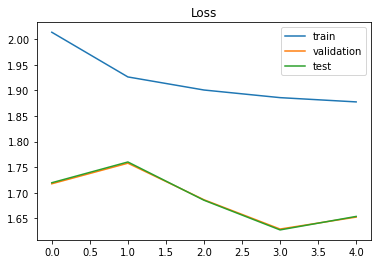

In [13]:
#### Fine_tune_ADAM PRETRAINED WITH ADAM ###
model_unfreeze_ADAM = PoemClassifier(is_freeze = False)
EPOCHS = 5
LR = 2e-4
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_unfreeze_ADAM.parameters(), lr= LR)
              
model_unfreeze_ADAM, total_loss_train_array_unfreeze_ADAM,total_loss_test_array_unfreeze_ADAM,total_loss_val_array_unfreeze_ADAM = train_and_evaluate(model_unfreeze_ADAM, train_dataloader, val_dataloader, test_dataloader, LR, EPOCHS, criterion, optimizer)
# save model and result
torch.save(model_unfreeze_ADAM.state_dict(), 'model_unfreeze_ADAM.pt')
np.save('total_loss_train_array_unfreeze_ADAM.npy', total_loss_train_array_unfreeze_ADAM)
np.save('total_loss_test_array_unfreeze_ADAM.npy', total_loss_test_array_unfreeze_ADAM)
np.save('total_loss_val_array_unfreeze_ADAM.npy', total_loss_val_array_unfreeze_ADAM)


In [14]:
## confusion matrix , ... ##
report_model(model_unfreeze_ADAM,test_dataloader,'unFreeze with ADAM')

~~~~~~~~~~~~ unFreeze with ADAM ~~~~~~~~~~~~ 

               precision    recall  f1-score   support

  sanaee_norm       0.18      0.30      0.23       587
  onsori_norm       0.85      0.77      0.81      4959
    seyf_norm       0.33      0.38      0.35       992
ferdousi_norm       0.31      0.43      0.36      1516
    feyz_norm       0.14      0.46      0.22       376
  eraghi_norm       0.29      0.23      0.25      1429
  ouhadi_norm       0.03      0.28      0.06       100
   kamal_norm       0.57      0.12      0.20      2678
  vahshi_norm       0.31      0.32      0.32      1264
 roodaki_norm       0.27      0.28      0.27      1028

     accuracy                           0.44     14929
    macro avg       0.33      0.36      0.31     14929
 weighted avg       0.52      0.44      0.45     14929

confusion matrix : 
 [[ 179   26   78   65   24   64   22   22   51   56]
 [  72 3841   55  201  227  116  232   22   44  149]
 [ 112   22  372  146   61   68   43   26   88   54]


In [19]:
criterion = nn.CrossEntropyLoss()
perplexity1, perplexity2 = perplexity(model_freeze_ADAM, model_unfreeze_ADAM, test_dataloader,criterion)
print(f"Before Fine-tuning: {perplexity1:>0.4f}")  
print(f"After Fine-tuning: {perplexity2:>0.4f}")  


Before Fine-tuning: 5.3417
After Fine-tuning: 5.2274
